# The freMTPL2freq dataset

Welcome to the glamorous world of motor insurance! In this workshop, you'll work with a real-world French motor third‑party liability dataset, a classic benchmark dataset for [claim frequency modeling](https://openacttexts.github.io/Loss-Data-Analytics/ChapFrequency-Modeling.html) (i.e., *how many claims do we expect per policy-year?*). The dataset comes from [CASdatasets](https://dutangc.github.io/CASdatasets/).

Each row corresponds to a single insurance policy exposure period, with the following columns:

- `IDpol`: The policy ID.
- `ClaimNb`: Number of claims during the exposure period.
- `Exposure`: The brand of the car, divided into unknown categories.
- `VehPower`: The power of the car (ordered values).
- `VehAge`: The vehicle age, in years
- `DrivAge`: The driver age, in years (in France, people can drive a car at 18)
- `BonusMalus`: Risk-based rating factor between 50 and 350 (threshold expected to be at 100).
- `VehBrand`: The car brand (unknown categories).
- `VehGas`: The car's fuel type (Diesel or Regular).
- `Area`: discretized (binned) version of population density (from "A" for rural area to "F" for urban centre).
- `Density`: The density of inhabitants (number of inhabitants per square-kilometer) of the city where the car driver lives in.
- `Region`: The policy region in France.

Below you'll find some possible starting points. Pick the level that best suits
you, dig in, or ignore them and do your own thing. Happy coding!


##### **Beginner**
- Start by getting oriented with `.head()`, `.info()`, `.describe()`.
    - How many rows/columns do you have?
    - Which columns are numeric vs categorical?
    - Are there missing values? If yes: where and how many?

- Sanity-check the basics:
    - What is total exposure in the dataset: `df["Exposure"].sum()`?
    - How many total claims: `df["ClaimNb"].sum()`?
    - What is the overall claim frequency (claims per year)?
    - Hint: a good baseline is `total_claims / total_exposure`.

- Claim counts are usually *very* skewed. Here are some questions you could answer:
    - Plot the distribution of `ClaimNb`.
    - What fraction of rows have `ClaimNb = 0`?
    - What's the maximum `ClaimNb`? Inspect a few of the largest-claim rows.

- Explore the categorical columns using `.value_counts()`:
    - `VehBrand`, `VehGas`, `Region`, `VehPower`  
    Which ones have many levels? Any very rare categories?

- Build your first "actuarial" summary table:
    - Compute claim rate (claim frequency per 1 unit exposure) by `VehGas` and by `Region`.
    - Important hint: don't average `ClaimNb / Exposure` row-by-row at first, instead compute `sum(ClaimNb) / sum(Exposure)` within each group.



##### **Intermediate**
-  Try out creating a rate column, which would be the claim frequency per 1 unit exposure:
    - Define `ClaimFreq = ClaimNb / Exposure`
    - Before you do: check if any `Exposure` is 0 or extremely small. What would that do to `ClaimFreq`?

- Make risk buckets (this dataset loves buckets) using [`pd.cut()`](https://pandas.pydata.org/docs/reference/api/pandas.cut.html):
    - Bin `DrivAge` into age groups (e.g. 18-25, 26-35, etc.)
    - Bin `VehAge` into "new-ish" vs "old-ish" (or more bins).

- Build a mini "pricing table":
    - For each of these, compute `sum(ClaimNb) / sum(Exposure)` and rank groups:
        - `Region`
        - `VehPower`
        - `VehBrand` (any rare brands?)
        - combinations like `(Region, VehGas)` or `(DrivAgeGroup, VehPower)`

- Bonus/malus is meant to be informative, lets test that it is:
    - Plot claim rate as a function of `BonusMalus` (bin it if it has many unique values).
    - Is the relationship monotone? Are there weird plateaus or jumps?

- Visual storytelling ideas:
    - A heatmap of claim rates for `(DrivAgeGroup x VehPower)` or `(Region x VehGas)`.
    - A "risk profile" plot: predicted/observed claim rate vs driver age group.


##### **Advanced**
- Try out building a proper frequency model (the canonical approach):
    - Split into train/test (or use cross-validation).
    - Fit a [Poisson GLM](https://en.wikipedia.org/wiki/Poisson_regression) with a log link and `Exposure` as an *offset*:
        - Model `ClaimNb ~ features + offset(log(Exposure))`
        - If you use `statsmodels`, look into [`GLM`](https://www.statsmodels.org/stable/glm.html).

- Perhaps the claim frequency is not actually Poisson distributed here? A common problem is "overdispersion", i.e. that `Var(ClaimNb)` is much larger than `Mean(ClaimNb)`. Does this hold in our data, and does this contradict the Poisson distribution? You might compare Poisson vs [Negative Binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) (and see if it helps in the modeling).

- Another idea is to go nonlinear:
    - Fit a tree/boosting model with a Poisson objective (e.g. [XGBoost](https://xgboost.readthedocs.io/en/stable/), [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html), or [CatBoost](https://catboost.ai/docs/en/concepts/python-quickstart)).
    - Handle categoricals carefully (one-hot, target encoding, or a model that natively supports categoricals).
    - Don't forget exposure: use it as an offset (if supported) or as weights + careful target definition.

- Interpretability (because "why does the model think that?"):
    - For GLMs: interpret coefficients (and check multicollinearity).
    - For boosting: try [SHAP](https://shap.readthedocs.io/en/latest/) and inspect whether effects make sense (e.g., BonusMalus, age, density).
    - Cutting edge: try out the [Explainable Boosting Machine (EBM)](https://interpret.ml/docs/ebm.html), which is a boosting method known to give performance at par with SOTA boosting methods while remaining interpretable.

In [1]:
import pandas as pd

df = pd.read_csv('freMTPL2freq.csv')
df.head()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region
0,1.0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
1,3.0,1,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
2,5.0,1,0.75,6,2,52,50,B12,Diesel,B,54,Picardie
3,10.0,1,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine
4,11.0,1,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine


In [ ]:
df.dtypes

IDpol         float64
ClaimNb         int64
Exposure      float64
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Area           object
Density         int64
Region         object
dtype: object

In [ ]:
# 2. Lista numeriska kolumner (int, float)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print('Numeriska kolumner:', numeric_cols)

# 3. Lista text-/kategorikolumner (object, string)
text_cols = df.select_dtypes(include=['object']).columns.tolist()
print('Text-/kategorikolumner:', text_cols)

Numeriska kolumner: ['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
Text-/kategorikolumner: ['VehBrand', 'VehGas', 'Area', 'Region']


In [ ]:
# 1. Antal saknade per kolumn
#df.isna().sum()

# 2. Andel saknade per kolumn (i %)
#(df.isna().sum() / len(df) * 100).round(2)

# 3. Totalt antal saknade i hela datan
#df.isna().sum().sum()

# 4. Visa rader som har minst ett saknat värde
#df[df.isna().any(axis=1)]

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region


In [50]:
df['Exposure'].sum()


np.float64(358499.44546217704)

In [51]:
df['ClaimNb'].sum()

np.int64(36102)

(0.0, 1.0)

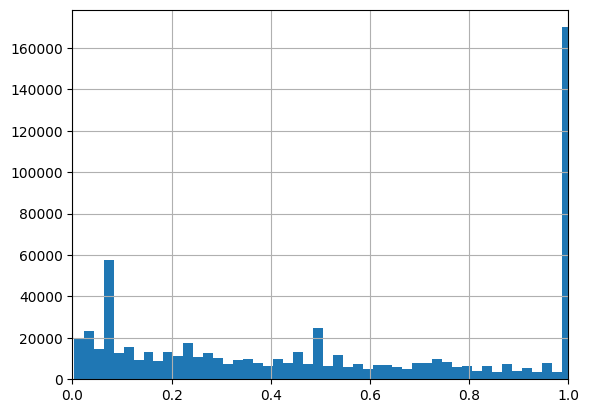

In [53]:
ax = df['Exposure'].hist(bins=100)
ax.set_xlim(0, 1)

(0.0, 5.0)

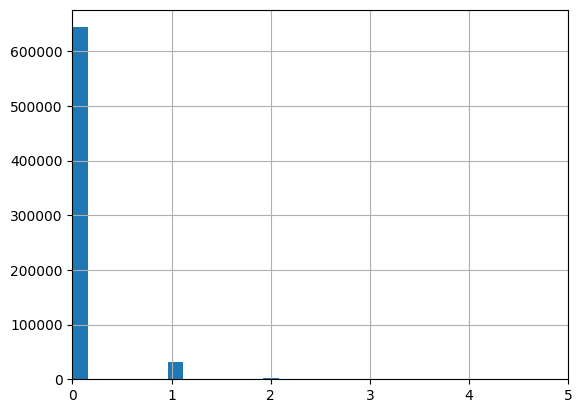

In [59]:
ax = df['ClaimNb'].hist(bins=100)
ax.set_xlim(0, 5)

In [61]:
df['ClaimNb'].std()

np.float64(0.24011733044675995)